# Corrupt LES lidar scans to look more like real-world lidar scans
I add random blade strikes and noise to data.

Blade strike strategy: try to do alternating blade strikes, but also add in some random bonus strikes sometimes.

Noisy strategy: follow real-world lidar noise behavior that is documented in Rye and Hardest (1993) + Newsom 2017. In the lidar "near-field", noise has an exponentially growing sigma that comes from a Gaussian distribution. In the "far field", noise has a constant sigma that comes from a uniform distribution. I pick the maximum sigma by eyeballing similar noise levels that I observe in real-world lidar measurements. Afterwards, I pick the transition location by also qualitatively matching against real-world lidar measurements.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from scipy.ndimage import gaussian_filter
import xarray as xr

np.random.seed(0)

In [2]:
### Prepare to read data
in_dir = Path('/scratch/orybchuk/wakedynamics/bcs-ldm/simulations/072415/large_campaigns/precursor/postprocessing/reformatted')
out_dir = Path(in_dir.parent, 'corrupted')
out_dir.mkdir(exist_ok=True)

b_files = list(in_dir.glob('inflow_b2lev*.nc'))
b_files.sort()
n_campaigns = len(b_files)

In [3]:
### Corruption parameters
## Blade strikes
missing_data_pct0 = 66  # This should functionally be divided by 2; it's for alternating strikes
missing_data_pct1 = 10  # This is for totally random strikes

## Noise
##   Stefano recommends following something like Fig. 3 from
##   https://amt.copernicus.org/articles/10/1229/2017/amt-10-1229-2017.pdf
# Structure range to be piecewise linear (0-->600) + (600-->beyond)
# In SNR space, the transition would happen at around an SNR of around -12 to -15
rws_thresh_max = 18
rws_thresh_min = 3
range_coords = np.arange(0.0, 996.0, 12.0)  
sigma_vs_range = np.zeros_like(range_coords)

## Maximum range
max_range = 5 * 130  


#   Instead of one linear region and one flat region,
#   do two linear regions
#   I'm following Newsom's AWAKEN powerpoint for approx values
range_lo0, sigma_lo0 = 0.0, 5e-4
range_hi0, sigma_hi0 = 240, 3e-2
range_lo1, sigma_lo1 = range_hi0, sigma_hi0
range_hi1, sigma_hi1 = 996.0, 8e0

logbase = 10
start_piecewise0 = np.power(sigma_lo0, 1/float(logbase))
stop_piecewise0 = np.power(sigma_hi0, 1/float(logbase))
range_piecewise0 = np.arange(range_lo0, range_hi0, 12.0)  
noise_piecewise0 = np.sqrt( np.power( np.linspace(start_piecewise0, stop_piecewise0, num=len(range_piecewise0)), logbase) )  # TODO: Not actually exponential spacing?

start_piecewise1 = np.power(sigma_lo1, 1/float(logbase))
stop_piecewise1 = np.power(sigma_hi1, 1/float(logbase))
range_piecewise1 = np.arange(range_lo1, range_hi1, 12.0)  
noise_piecewise1 = np.sqrt( np.power( np.linspace(start_piecewise1, stop_piecewise1, num=len(range_piecewise1)), logbase) )  # TODO: Not actually exponential spacing?

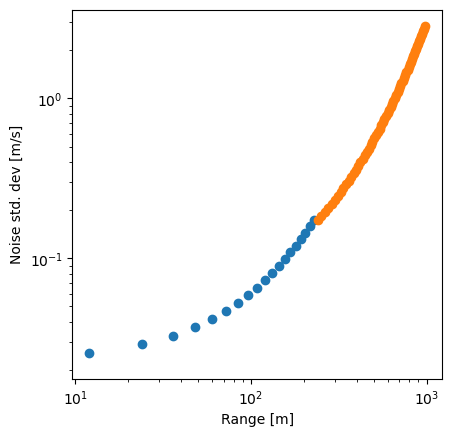

In [4]:
### Double check that I'm doing exponentially growing noise
fig, ax = plt.subplots(1, 1)

ax.set_box_aspect(1)

ax.scatter(range_piecewise0, noise_piecewise0)
ax.scatter(range_piecewise1, noise_piecewise1)


ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(0, 600)

ax.set_xlabel('Range [m]')
ax.set_ylabel('Noise std. dev [m/s]')

plt.show()

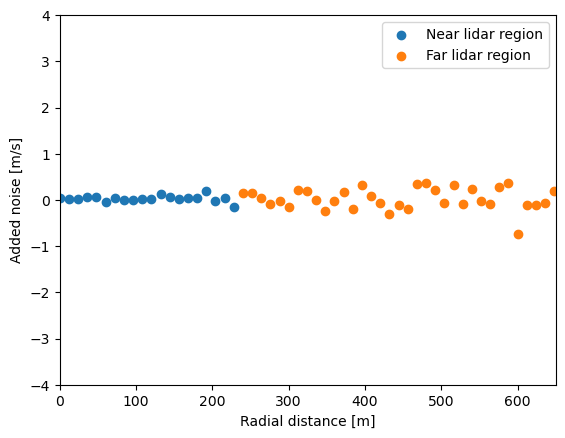

In [5]:
### Plot some realizations of white noise
fig, ax = plt.subplots(1, 1)

demo_noise0 = np.random.normal(loc=0,
                 scale=noise_piecewise0,
                 size=(200,16,len(range_piecewise0))).T

demo_noise1 = np.random.uniform(low=-1*noise_piecewise1,  # Uniform white noise
             high=noise_piecewise1,
             size=(200,16,len(range_piecewise1))).T

ax.scatter(range_piecewise0, demo_noise0[:,0,0], label='Near lidar region')
ax.scatter(range_piecewise1, demo_noise1[:,0,0], label='Far lidar region')
# ax.scatter(range_cozords, demo_noise2[:,0,-1])
# ax.scatter(range_coords, demo_noise2[:,-1,0])

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0, max_range)
ax.set_ylim(-4, 4)

ax.set_xlabel('Radial distance [m]')
ax.set_ylabel('Added noise [m/s]')
ax.legend()

plt.show()

In [6]:
# for icampaign, fcampaign in enumerate(b_files[:5]):
for icampaign, fcampaign in enumerate(b_files):
    if icampaign % 25 == 0: print(datetime.now(), icampaign, '...')
    campaign_id = fcampaign.name[12:16]
    
    ### ~~~~~~~~~~ Read b2-level data ~~~~~~~~~~
    ds_b2 = xr.open_dataset(fcampaign)
    n_beams = len(ds_b2['beam'])
    n_reps = len(ds_b2['rep'])
    n_range = len(ds_b2['range'])
    n_timesteps = len(ds_b2['time'].values.flatten())

    ### ~~~~~~~~~~ Add smoothing ~~~~~~~~~~
    # TODO
    # First, attempt simple Gaussian smoothing
    # TODO: Upgrade to more realistic smoothing from
    #   Stawiarski (2013), eq 3 & 4
    smoothing_widths = (2,0,0)  # (3,0,0) chosen by eye
    
    ds_smoothed = ds_b2.copy()
    ds_smoothed['rws'].data = gaussian_filter(ds_b2['rws'].values, sigma=smoothing_widths)
    
    ### ~~~~~~~~~~ Add random beam strikes ~~~~~~~~~~
    # drop_data_flag = np.random.randint(low=0, high=100, size=n_timesteps)
    # drop_data_flag = drop_data_flag < missing_data_pct
    # drop_data_flag = drop_data_flag.reshape((n_beams, n_reps))
    
    drop_data_flag = np.random.randint(low=0, high=100, size=n_timesteps//2)
    drop_data_flag = drop_data_flag < missing_data_pct0
    drop_data_filler = np.zeros(n_timesteps//2).astype(int)  # Add a filler to promote alternating strike/meas
                                                 # Problem: only half the beams are ever masked
    drop_data_flag = np.vstack((drop_data_flag, drop_data_filler)).T
    drop_data_flag = drop_data_flag.astype(bool)
    
    # Calculate an alternating strike pattern
    for irep in range(0,n_timesteps//n_beams,2):  # Shuffle data so all beams are masked at some point,
                                                  # but also preserve the alternating beam strike vibe
        ind_start = irep * n_beams
        ind_end = (irep+1) * n_beams
        drop_data_flag[ind_start:ind_end,1] = drop_data_flag[ind_start:ind_end,0]
        drop_data_flag[ind_start:ind_end,0] = False
    drop_data_flag = drop_data_flag.flatten(order='C')
    drop_data_flag = drop_data_flag.reshape((n_beams, n_reps), order='F')
    drop_data_mask = drop_data_flag + 1.0
    
    # Add in totally random strikes
    random_strike_flag = np.random.randint(low=0, high=100, size=drop_data_mask.shape)
    random_strike_flag = random_strike_flag < missing_data_pct1
    
    drop_data_mask += random_strike_flag
    
    drop_data_mask[drop_data_mask>1]=np.nan
    
    rws_data = ds_smoothed['rws'].data
    strike_data = rws_data * drop_data_mask
    ds_strike = ds_smoothed.copy()
    ds_strike['rws'].data = strike_data
    
    ### ~~~~~~~~~~ Add noise ~~~~~~~~~~
    ds_noisy = ds_strike.copy()

    noise_realization_close = np.random.normal(loc=0,  # Near-lidar region, Gaussian white noise
                     scale=noise_piecewise0,
                     size=(n_reps,n_beams,len(range_piecewise0))).T
    noise_realization_far = np.random.uniform(low=-1*noise_piecewise1,  # Far-lidar region, Uniform white noise
                 high=noise_piecewise1,
                 size=(n_reps,n_beams,len(range_piecewise1))).T    
    noise_realization = np.concatenate((noise_realization_close, noise_realization_far), axis=0)
    
    ds_noisy['rws'].data = ds_noisy['rws'].data + noise_realization
    ds_noisy['rws'].data = ds_noisy['rws'].where(ds_noisy['rws'] > rws_thresh_min).data  # Set data beyond thresholds to NaN
    ds_noisy['rws'].data = ds_noisy['rws'].where(ds_noisy['rws'] < rws_thresh_max).data
    
    ## Drop more pixels randomly
    ##   Increase outage likelihood further away
    random_outage_pct0 = 2
    random_outage_pct1 = 25
    random_outage_length0 = int(n_range//2)
    random_outage_length1 = n_range - random_outage_length0
    random_outages0 = np.random.randint(low=0, high=100, size=(random_outage_length0, n_beams, n_reps))
    random_outages0 = random_outages0 < random_outage_pct0
    random_outages1 = np.random.randint(low=0, high=100, size=(random_outage_length1, n_beams, n_reps))
    random_outages1 = random_outages1 < random_outage_pct1
    random_outages = np.concatenate((random_outages0, random_outages1)).astype(float)
    random_outages[random_outages==1]=np.nan
    
    ds_noisy['rws'].data = ds_noisy['rws'].data + random_outages
    
    ### ~~~~~~~~~~ Filter beyond maximum range ~~~~~~~~~~
    ds_noisy['rws'] = ds_noisy['rws'].where(ds_noisy['range'] < max_range)
    
    ds_noisy.to_netcdf(Path(out_dir, fcampaign.name))

2024-05-17 15:41:02.913718 0 ...
2024-05-17 15:41:03.959646 25 ...
2024-05-17 15:41:04.731824 50 ...
2024-05-17 15:41:05.508006 75 ...
2024-05-17 15:41:06.265770 100 ...
2024-05-17 15:41:07.027838 125 ...
2024-05-17 15:41:07.794036 150 ...
2024-05-17 15:41:08.561142 175 ...
2024-05-17 15:41:09.342420 200 ...
2024-05-17 15:41:10.104690 225 ...
2024-05-17 15:41:10.872727 250 ...
2024-05-17 15:41:11.652286 275 ...
2024-05-17 15:41:12.437965 300 ...
2024-05-17 15:41:13.219616 325 ...


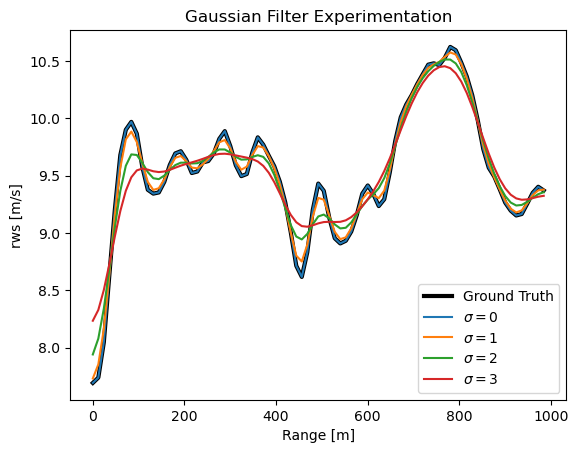

In [7]:
fig, ax = plt.subplots(1, 1)

data0 = ds_b2['rws'].isel(beam=0, rep=1)
data1 = gaussian_filter(data0, sigma=0)
data2 = gaussian_filter(data0, sigma=1)
data3 = gaussian_filter(data0, sigma=2)
data4 = gaussian_filter(data0, sigma=3)

ax.plot(ds_b2['range'], data0, color='k', lw=3, label='Ground Truth')
ax.plot(ds_b2['range'], data1, label='$\sigma=0$')
ax.plot(ds_b2['range'], data2, label='$\sigma=1$')
ax.plot(ds_b2['range'], data3, label='$\sigma=2$')
ax.plot(ds_b2['range'], data4, label='$\sigma=3$')
        
ax.legend()

ax.set_xlabel('Range [m]')
ax.set_ylabel('rws [m/s]')
ax.set_title('Gaussian Filter Experimentation')

plt.show()

In [8]:
# ### Plot a single frame
# ## Helpful parameters
# uinf = 9.03
# D = 130
# vmin, vmax = 60, 130
# cmap = 'coolwarm'

# time_beam0 = ds_strike['time'].sel(beam=0)

# # Initialize
# dataiter_in = 4

# fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=125, sharex=True, sharey=True)

# ## Decorate
# plt.suptitle(pd.Timestamp(time_beam0.values[dataiter_in]).strftime('%H:%M:%S'), y=0.95)
# ax.set_title("Traditional, concatenated scans (LES-derived)")

# xmin, xmax = -8*D, 1*D
# ymin, ymax = -2*D, 2*D
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# ax.set_box_aspect((ymax-ymin)/(xmax-xmin))

# ax.set_ylabel('$y$ [m]')
# ax.set_xlabel('$x$ [Rotor Diameter, $D$=130 m]')

# ax.set_xticks(D*np.arange(-8, 2))
# ax.set_xticklabels(np.arange(-8, 2).astype(str))
# ax.set_yticks(D*np.arange(-2, 3))
# ax.set_yticklabels(np.arange(-2, 3).astype(str))

# ax.axvline(-3*D,
#             color='k',
#             alpha=0.1,
#             ls='--',
#             label='x=-3D')
# ax.text(0.55,
#           0.8,
#           "x=-3D",
#           fontsize=9,
#           transform = ax.transAxes,
#           horizontalalignment='right',
#           color='k',
#           alpha=0.4,
#           rotation=90)

# im0 = ax.pcolor(ds_strike['X'],
#                     ds_strike['Y'], 
#                     100 * ds_strike['rws'].sel(rep=dataiter_in) / uinf,
#                     vmin=vmin,
#                     vmax=vmax,
#                     cmap=cmap,
#                     shading="auto")

# ### Colorbar
# cax0 = fig.add_axes([ax.get_position().x1+0.02,
#                      ax.get_position().y0,
#                      0.02,
#                      ax.get_position().y1-ax.get_position().y0])
# cbar0 = fig.colorbar(im0, cax=cax0)
# cbar0.set_label('$RWS$ / $U_{inf}$ [%]')
# cbar0.ax.tick_params()

# plt.show()

In [9]:
# ### Plot a single frame
# ## Helpful parameters
# uinf = 9.03
# D = 130
# vmin, vmax = 60, 130
# cmap = 'coolwarm'

# time_beam0 = ds_strike['time'].sel(beam=0)

# # Initialize
# dataiter_in = 4

# fig, ax = plt.subplots(3, 1, figsize=(8,7), dpi=125, sharex=True, sharey=True)

# ## Decorate
# plt.suptitle(pd.Timestamp(time_beam0.values[dataiter_in]).strftime('%H:%M:%S'), y=0.94)
# ax[0].set_title("Traditional, concatenated scans (LES-derived)")
# ax[1].set_title("Scans with detector saturation")
# ax[2].set_title("Scans with detector saturation + noise")

# xmin, xmax = -8*D, 1*D
# ymin, ymax = -2*D, 2*D
# ax[0].set_xlim(xmin, xmax)
# ax[0].set_ylim(ymin, ymax)

# ax[-1].set_xlabel('$x$ [Rotor Diameter, $D$=130 m]')

# ax[-1].set_xticks(D*np.arange(-8, 2))
# ax[-1].set_xticklabels(np.arange(-8, 2).astype(str))


# for axs in ax:
#     axs.set_box_aspect((ymax-ymin)/(xmax-xmin))
#     axs.set_yticks(D*np.arange(-2, 3))
#     axs.set_yticklabels(np.arange(-2, 3).astype(str))
#     axs.set_ylabel('$y$ [m]')
    
#     axs.axvline(-3*D,
#                 color='k',
#                 alpha=0.1,
#                 ls='--',
#                 label='x=-3D')
#     axs.text(0.55,
#               0.75,
#               "x=-3D",
#               fontsize=9,
#               transform = axs.transAxes,
#               horizontalalignment='right',
#               color='k',
#               alpha=0.4,
#               rotation=90)

# im0 = ax[0].pcolor(ds_strike['X'],
#                     ds_strike['Y'], 
#                     100 * ds_b2['rws'].sel(rep=dataiter_in) / uinf,
#                     vmin=vmin,
#                     vmax=vmax,
#                     cmap=cmap,
#                     shading="auto")

# im1 = ax[1].pcolor(ds_strike['X'],
#                     ds_strike['Y'], 
#                     100 * ds_strike['rws'].sel(rep=dataiter_in) / uinf,
#                     vmin=vmin,
#                     vmax=vmax,
#                     cmap=cmap,
#                     shading="auto")

# im2 = ax[2].pcolor(ds_strike['X'],
#                     ds_strike['Y'], 
#                     100 * ds_noisy['rws'].sel(rep=dataiter_in) / uinf,
#                     vmin=vmin,
#                     vmax=vmax,
#                     cmap=cmap,
#                     shading="auto")

# ### Colorbar
# cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
#                      ax[-1].get_position().y0,
#                      0.02,
#                      ax[0].get_position().y1-ax[-1].get_position().y0])
# cbar0 = fig.colorbar(im0, cax=cax0)
# cbar0.set_label('$RWS$ / $U_{inf}$ [%]')
# cbar0.ax.tick_params()

# plt.subplots_adjust(hspace=0.3)

# plt.show()

/tmp/scratch/4082672/ipykernel_2240917/824343935.py:54: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im0 = ax[0].pcolor(ds_strike['X'],
/tmp/scratch/4082672/ipykernel_2240917/824343935.py:62: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im1 = ax[1].pcolor(ds_strike['X'],
/tmp/scratch/4082672/ipykernel_2240917/824343935.py:70: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im2 = ax[2].pcolor(ds_strike['

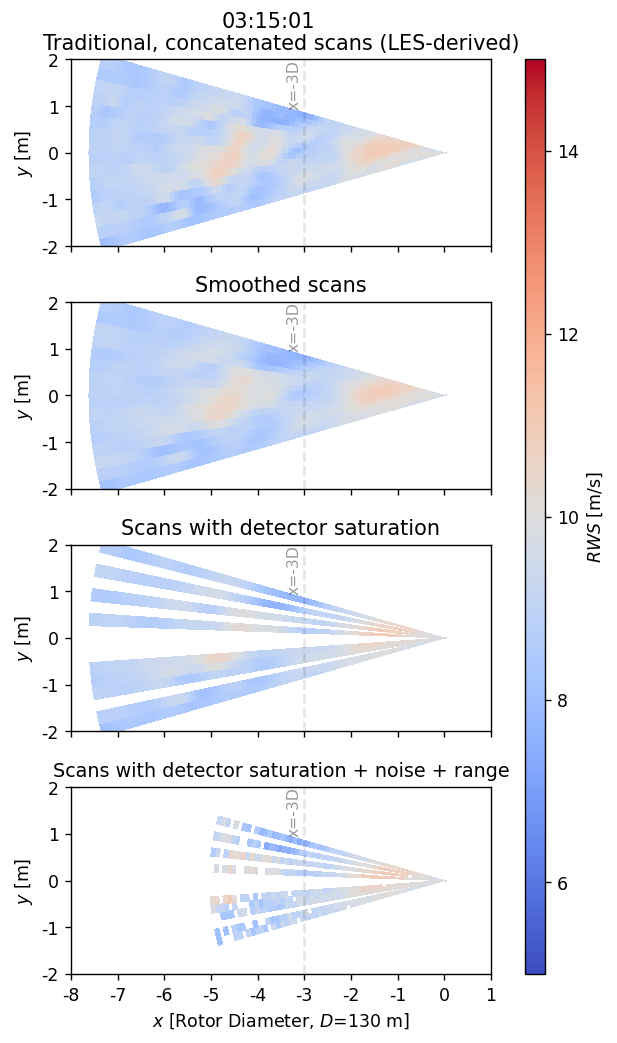

In [10]:
### Plot a single frame
## Helpful parameters
uinf = 9.03
D = 130
vmin, vmax = 60, 130
cmap = 'coolwarm'

time_beam0 = ds_strike['time'].sel(beam=0)

# Initialize
dataiter_in = 50

fig, ax = plt.subplots(4, 1, figsize=(8,9.5), dpi=125, sharex=True, sharey=True)

## Decorate
plt.suptitle(pd.Timestamp(time_beam0.values[dataiter_in]).strftime('%H:%M:%S'), y=0.92)
ax[0].set_title("Traditional, concatenated scans (LES-derived)")
ax[1].set_title("Smoothed scans")
ax[2].set_title("Scans with detector saturation")
ax[3].set_title("Scans with detector saturation + noise + range", fontsize=11)

xmin, xmax = -8*D, 1*D
ymin, ymax = -2*D, 2*D
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)

ax[-1].set_xlabel('$x$ [Rotor Diameter, $D$=130 m]')

ax[-1].set_xticks(D*np.arange(-8, 2))
ax[-1].set_xticklabels(np.arange(-8, 2).astype(str))


for axs in ax:
    axs.set_box_aspect((ymax-ymin)/(xmax-xmin))
    axs.set_yticks(D*np.arange(-2, 3))
    axs.set_yticklabels(np.arange(-2, 3).astype(str))
    axs.set_ylabel('$y$ [m]')
    
    axs.axvline(-3*D,
                color='k',
                alpha=0.1,
                ls='--',
                label='x=-3D')
    axs.text(0.55,
              0.75,
              "x=-3D",
              fontsize=9,
              transform = axs.transAxes,
              horizontalalignment='right',
              color='k',
              alpha=0.4,
              rotation=90)

im0 = ax[0].pcolor(ds_strike['X'],
                    ds_strike['Y'], 
                    ds_b2['rws'].sel(rep=dataiter_in),
                    vmin=5,
                    vmax=15,
                    cmap=cmap,
                    shading="auto")

im1 = ax[1].pcolor(ds_strike['X'],
                    ds_strike['Y'], 
                    ds_smoothed['rws'].sel(rep=dataiter_in),
                    vmin=5,
                    vmax=15,
                    cmap=cmap,
                    shading="auto")

im2 = ax[2].pcolor(ds_strike['X'],
                    ds_strike['Y'], 
                    ds_strike['rws'].sel(rep=dataiter_in),
                    vmin=5,
                    vmax=15,
                    cmap=cmap,
                    shading="auto")

im3 = ax[3].pcolor(ds_strike['X'],
                    ds_strike['Y'], 
                    ds_noisy['rws'].sel(rep=dataiter_in),
                    vmin=5,
                    vmax=15,
                    cmap=cmap,
                    shading="auto")

### Colorbar
cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$RWS$ [m/s]')
cbar0.ax.tick_params()

plt.subplots_adjust(hspace=0.3)

plt.show()